# Proyecto 04 - Reconocimiento de lenguaje de señas

## **Dataset**

In [180]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix

In [181]:
#load
data_test = pd.read_csv('.\data\sign_mnist_test.csv')
data_train = pd.read_csv('.\data\sign_mnist_train.csv')
data_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [182]:
print("Cantidad de pixeles: ", data_test.shape[1]-1)
print("Tamaño de cada imagen: ", np.sqrt(data_test.shape[1]-1), " x ", np.sqrt(data_test.shape[1]-1))
print("Cantidad de imagenes de entrenamiento: ", data_train.shape[0])

Cantidad de pixeles:  784
Tamaño de cada imagen:  28.0  x  28.0
Cantidad de imagenes de entrenamiento:  27455


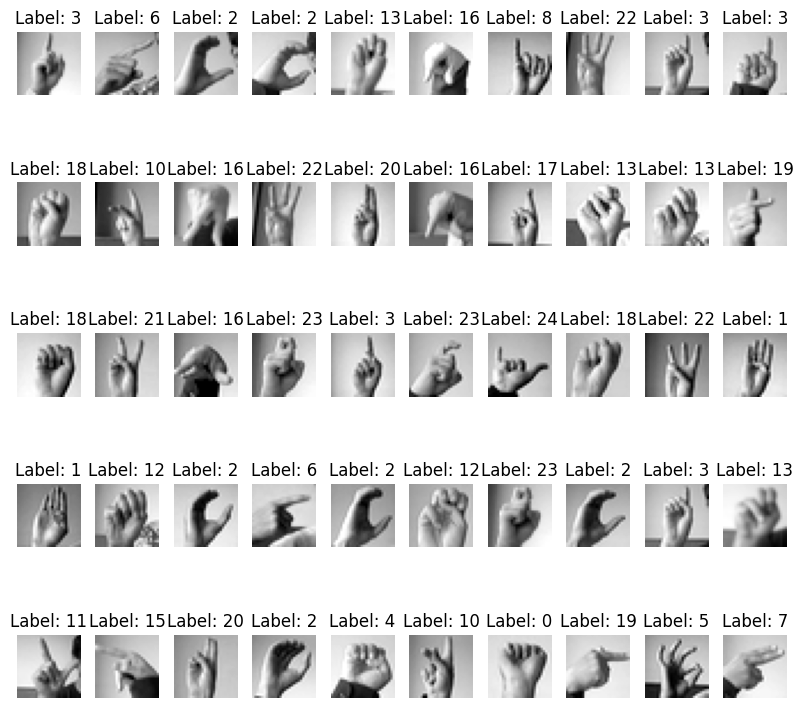

In [183]:
# Crear un mosaico de imágenes
n_rows = 5
n_cols = 10
plt.figure(figsize=(8, 8))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = data_train.iloc[i, 1:].values.reshape(28, 28)  # Remodelar a 28x28
    label = data_train.iloc[i, 0]
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Convolución**

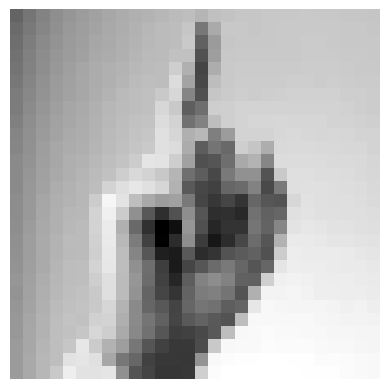

In [184]:

plt.imshow(image1, cmap='gray')
plt.axis('off')
plt.show()

In [185]:
# image_padded = np.pad(image1, pad_width=1, mode='constant', constant_values=0)
# plt.imshow(image_padded, cmap='gray')
# plt.axis('off')
# plt.show()
# image_padded
#image_padded[0*5:0*5 + kernel.shape[0], 2*5:2*5 + kernel.shape[0]]

In [186]:
def Convolusion(image, kernel, stride, padding):
    if image.shape != (28, 28):
        image = image.reshape(28, 28)
        
    image_padded = np.pad(image, pad_width=padding, mode='constant', constant_values=0)
    new_size = int(((image_padded.shape[0] - kernel.shape[0]) / stride) + 1)
    image_conv = np.zeros((new_size, new_size))

    for i in range(new_size):
        for j in range(new_size):
            image_conv[i, j] = np.sum(image_padded[i*stride:i*stride + kernel.shape[0], j*stride:j*stride + kernel.shape[0]] * kernel)

    return image_conv

(-0.5, 27.5, 27.5, -0.5)

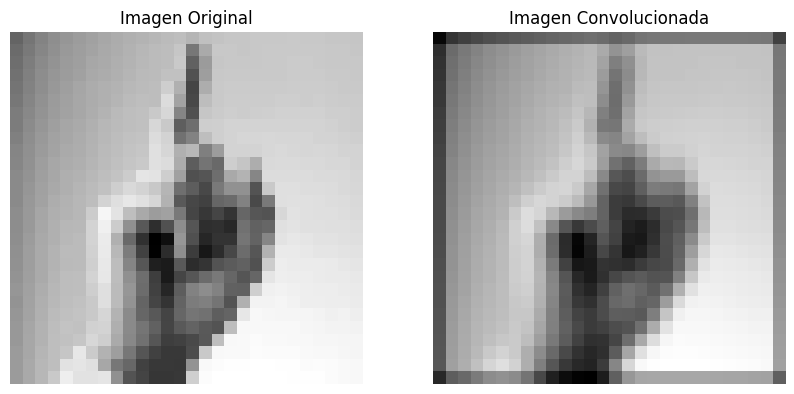

In [198]:
image1 = data_train.iloc[0, 1:].values.reshape(28, 28)
kernel_identity = np.array([[0,0,0], [0,1,0], [0, 0, 0]])
kernel_blur = np.array([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]])
kernel_sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kernel_BottomSobel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
kernel_emboss = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
kernel_leftSobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel_outline = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
kernel_rightSobel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
kernel_topSobel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

conv_image = Convolusion(image1, kernel_blur, 1, 1)

plt.figure(figsize=(10, 5))
# Dibujar image1
plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

# Dibujar conv_image
plt.subplot(1, 2, 2)
plt.imshow(conv_image, cmap='gray')
plt.title('Imagen Convolucionada')
plt.axis('off')